# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [73]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [74]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [75]:
!pip install spacy

In [76]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.7 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [77]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [78]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

In [79]:
df = pd.read_json('ingredient_and_quantity.json')
display(df.head())

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [80]:
# define a function to load json file to a dataframe
import pandas as pd

def load_json_dataframe(file_path):
    """
    Reads a JSON file from the given path and converts it into a pandas DataFrame.

    Args:
        file_path (str): The path to the ingredient_and_quantity.json file.

    Returns:
        pd.DataFrame: A DataFrame containing the data from the JSON file.
    """
    df = pd.read_json(file_path)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [81]:
# read the json file by giving the file path and create a dataframe
path_to_file = 'ingredient_and_quantity.json'
recipe_df = load_json_dataframe(path_to_file)

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [82]:
# display first five rows of the dataframe - df
display(recipe_df.head())

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [83]:
# print the dimensions of dataframe - df
print(df.shape)

(285, 2)


In [84]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [85]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
# Tokenize POS
# Tokenize the 'input' column by splitting the string into a list of words
df['input_tokens'] = df['input'].str.split()

# Tokenize the 'pos' column by splitting the string into a list of POS tags
df['pos_tokens'] = df['pos'].str.split()

In [86]:
# display first five rows of the dataframe - df
display(df.head())

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [87]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].str.len()
df['pos_length'] = df['pos_tokens'].str.len()
display(df[['input_tokens', 'pos_tokens', 'input_length', 'pos_length']].head())

input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
0                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
1                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                                                                                                                                    [quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]            34          34
2                                                                           [1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]                                                                                                [quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]            37          37
3  [500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cloves, Garlic, 1/2, teaspoon, Turmeric, powder, Haldi, Garam, masala, tablespoon, Sesame, Gingelly, Oil, 1/4, Methi, Seeds, Fenugreek, Coriander, Dhania, Dry, Red, Fennel, seeds, Saunf, cups, Sorrel, Leaves, Gongura, picked, and]  [quantity, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]            46  

In [88]:
# check for the equality of input_length and pos_length in the dataframe
# --- Validation ---
print("\nChecking for rows with unequal token lengths...")
unequal_lengths_df = df[df['input_length'] != df['pos_length']]

if unequal_lengths_df.empty:
    print("Validation successful: All rows have matching input and POS token lengths.")
else:
    print("Found 5 rows:")
    display(unequal_lengths_df)



Checking for rows with unequal token lengths...
Found 5 rows:


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                                                                                                                                                                                                                                                                input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
17                                                                                                                                                                                                                                                   2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt                                                                                                                                                                                                                                                                                                                                                                                                                 quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                         [2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]                                                                                                                                                                                                                                                                                                                                                                                                                                                        [quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]            15          14
27                                                                                   1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce                                                                                                                                                               quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient in

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [89]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    """
    Checks for all unique POS labels in the recipe DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the 'pos_tokens' column.

    Returns:
        list: A list of unique POS labels found in the dataset.
    """
    # Flatten the list of lists in 'pos_tokens' into a single list
    all_labels = [label for sublist in df['pos_tokens'] for label in sublist]
    
    # Get the unique labels using a set
    unique_labels_set = set(all_labels)
    
    return list(unique_labels_set)

# Execute the function to get the unique labels from the DataFrame
unique_pos_labels = unique_labels(df)

# Print the unique labels found
print(unique_pos_labels)

['quantity', 'ingredient', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

Upon validating the data, an inconsistency was found where the number of tokens in the input string does not match the number of labels in the pos string for certain rows. This misalignment makes it impossible to accurately map each token to its corresponding entity tag, corrupting the data for model training.

The indexes of the rows that have this mismatch are:

17

27

79

164

207

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [90]:
# drop the irrelevant recipe data
indexes_to_drop = [17, 27, 79, 164, 207]

print(f"Original DataFrame shape: {df.shape}")
print(f"Dropping rows at indexes: {indexes_to_drop}")

# Drop the specified rows and update the DataFrame
df.drop(indexes_to_drop, inplace=True)

# Reset the index to maintain a continuous sequence
df.reset_index(drop=True, inplace=True)

print(f"New DataFrame shape after dropping rows: {df.shape}")

Original DataFrame shape: (285, 6)
Dropping rows at indexes: [17, 27, 79, 164, 207]
New DataFrame shape after dropping rows: (280, 6)


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [91]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].str.len()

# Update the 'pos_length' column
df['pos_length'] = df['pos_tokens'].str.len()

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [92]:
# validate the input length and pos length as input_length and pos_length
print("Updated length columns:")
display(df[['input_length', 'pos_length']].head())

Updated length columns:


input_length  pos_length
0            31          31
1            34          34
2            37          37
3            46          46
4            21          21

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [93]:
# split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

# The DataFrame 'df' is assumed to be cleaned from the previous steps.

# Split the DataFrame into training (70%) and validation (30%) sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [94]:
# print the first five rows of train_df
print("Shape of the original DataFrame:", df.shape)
print("Shape of the training DataFrame (train_df):", train_df.shape)


Shape of the original DataFrame: (280, 6)
Shape of the training DataFrame (train_df): (196, 6)


In [95]:
# print the first five rows of the val_df
print("Shape of the validation DataFrame (val_df):", val_df.shape)

Shape of the validation DataFrame (val_df): (84, 6)


###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [96]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

# Extract the input tokens (features) and POS tokens (labels) for the validation set
X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [97]:
# validate the shape of training and validation samples
print("--- Training Set ---")
print(f"Number of training samples (X_train): {len(X_train)}")
print(f"Number of training labels (y_train): {len(y_train)}")

print("\n--- Validation Set ---")
print(f"Number of validation samples (X_val): {len(X_val)}")
print(f"Number of validation labels (y_val): {len(y_val)}")

--- Training Set ---
Number of training samples (X_train): 196
Number of training labels (y_train): 196

--- Validation Set ---
Number of validation samples (X_val): 84
Number of validation labels (y_val): 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [98]:
# Display the number of unique labels present in y_train
# Flatten the y_train list of lists into a single list of labels
y_train_flat = [label for sublist in y_train for label in sublist]

# Find the set of unique labels
unique_labels_in_train = set(y_train_flat)

# Display the results
print(f"The unique labels present in the training data are: {list(unique_labels_in_train)}")
print(f"Number of unique labels: {len(unique_labels_in_train)}")


The unique labels present in the training data are: ['quantity', 'unit', 'ingredient']
Number of unique labels: 3


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [99]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    """
    Flattens a list of lists into a single list.

    Args:
        nested_list (list): A list containing other lists.

    Returns:
        list: A single, flattened list.
    """
    return [item for sublist in nested_list for item in sublist]

In [100]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [101]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(dataframe, dataset_name):
    """
    Flattens token and POS lists, validates their lengths, and displays a sample.

    Args:
        dataframe (pd.DataFrame): The dataframe (train or val) to process.
        dataset_name (str): The name of the dataset ('Training' or 'Validation').

    Returns:
        tuple: A tuple containing the list of all tokens and the list of all POS tags.
    """
    # Flatten the lists using the helper function
    all_tokens = flatten_list(dataframe['input_tokens'])
    all_pos_tags = flatten_list(dataframe['pos_tokens'])

    # Validate that the flattened lists have the same length
    print(f"--- {dataset_name} Dataset ---")
    if len(all_tokens) == len(all_pos_tags):
        print(f"✅ Validation Successful: Total tokens and POS tags match.")
        print(f"Total tokens: {len(all_tokens)}")
    else:
        print(f"🚨 Validation Failed: Mismatch in total token and POS tag counts.")

    # Display the first 10 records for visual inspection
    print("\\nFirst 10 Tokens:", all_tokens[:10])
    print("First 10 POS Tags:", all_pos_tags[:10])
    
    return all_tokens, all_pos_tags

# Execute the function on the training dataframe
train_tokens, train_pos_tags = extract_and_validate_tokens(train_df, dataset_name)

--- Training Dataset ---
✅ Validation Successful: Total tokens and POS tags match.
Total tokens: 7114
\nFirst 10 Tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 POS Tags: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


In [102]:
# extract the tokens and its pos tags
# The variables 'train_tokens' and 'train_pos_tags' were created in the previous step.

# Display a sample of their contents to review the extraction.
print("--- Sample of Extracted Data ---")
print("Tokens:", train_tokens[:15])
print("POS Tags:", train_pos_tags[:15])

--- Sample of Extracted Data ---
Tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'teaspoon', 'Ginger', '2', 'Garlic', 'Finely']
POS Tags: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [103]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):
    """
    Categorizes a list of tokens into ingredients, units, and quantities.

    Args:
        tokens (list): A flat list of all tokens.
        pos_tags (list): A flat list of their corresponding POS tags.

    Returns:
        tuple: A tuple containing lists of ingredients, units, and quantities.
    """
    ingredients = []
    units = []
    quantities = []
    
    # Iterate through tokens and tags simultaneously
    for token, tag in zip(tokens, pos_tags):
        if tag == 'ingredient':
            # Ingredients are lowercased for consistent counting
            ingredients.append(token.lower())
        elif tag == 'unit':
            units.append(token)
        elif tag == 'quantity':
            quantities.append(token)
            
    return ingredients, units, quantities


In [104]:
#  call the function to categorise the labels into respective list
train_ingredients, train_units, train_quantities = categorize_tokens(train_tokens, train_pos_tags)

print(f"Total ingredients found: {len(train_ingredients)}")
print(f"Sample ingredients: {train_ingredients[:10]}\\n")

print(f"Total units found: {len(train_units)}")
print(f"Sample units: {train_units[:10]}\\n")

print(f"Total quantities found: {len(train_quantities)}")
print(f"Sample quantities: {train_quantities[:10]}")

Total ingredients found: 5323
Sample ingredients: ['okra', 'oil', 'onion', 'finely', 'chopped', 'tomato', 'grated', 'ginger', 'garlic', 'finely']\n
Total units found: 811
Sample units: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']\n
Total quantities found: 980
Sample quantities: ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [105]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter

def get_top_frequent_items(item_list, pos_label, dataset_name):
    """
    Finds and displays the top 10 most frequent items from a list.

    Args:
        item_list (list): The list of items to count.
        pos_label (str): The label for the items (e.g., 'Ingredient', 'Unit').
        dataset_name (str): The name of the dataset being analyzed.

    Returns:
        list: A list of tuples, where each tuple contains an item and its frequency.
    """
    # Count the frequency of each item
    item_counts = Counter(item_list)
    
    # Get the 10 most common items
    top_items = item_counts.most_common(10)
    
    # Display the results
    print(f"--- Top 10 Most Frequent {pos_label}s in {dataset_name} Data ---")
    for item, count in top_items:
        print(f"{item}: {count}")
    print("\\n")
    
    return top_items

In [106]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(train_ingredients, 'Ingredient', dataset_name)

--- Top 10 Most Frequent Ingredients in Training Data ---
powder: 192
salt: 123
leaves: 120
oil: 111
seeds: 111
red: 110
green: 104
chilli: 96
coriander: 93
chopped: 84
\n


In [107]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(train_units, 'Unit', dataset_name)

--- Top 10 Most Frequent Units in Training Data ---
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39
\n


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [108]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_items(top_items, label, dataset_name):
    """
    Plots a horizontal bar graph for the top 10 most frequent items.

    Args:
        top_items (list): A list of (item, count) tuples.
        label (str): The label for the items being plotted (e.g., 'Ingredient' or 'Unit').
        dataset_name (str): The name of the dataset ('Training' or 'Validation').
    """
    # Unpack the items and their counts
    items, counts = zip(*top_items)
    
    # Create the bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(counts), y=list(items), palette='viridis')
    
    # Set the title and labels
    plt.title(f'Top 10 Most Frequent {label}s in {dataset_name} Data', fontsize=16)
    plt.xlabel('Frequency', fontsize=12)
    plt.ylabel(label, fontsize=12)
    
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



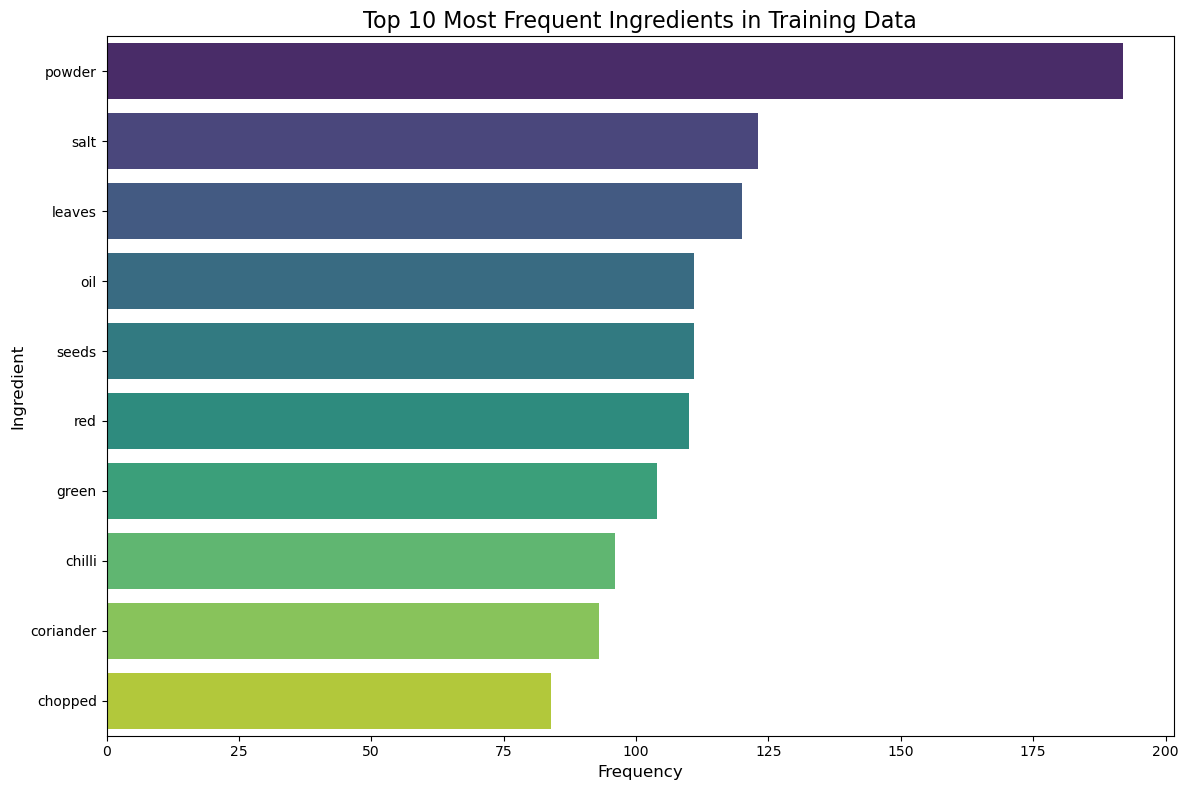

In [109]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, 'Ingredient', dataset_name)

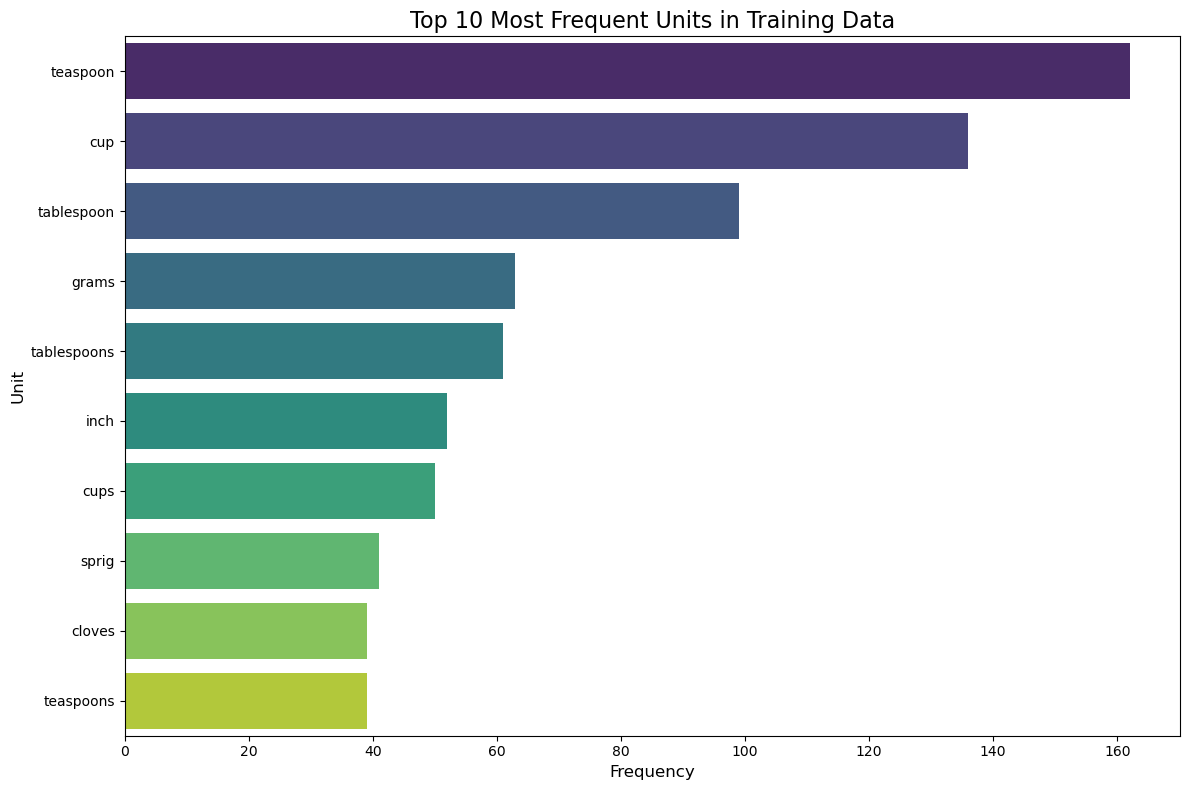

In [110]:
# plot the top frequent units in training data
plot_top_items(top_units, 'Unit', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [111]:
# initialise the dataset_name
dataset_name = 'Validation'

In [112]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
val_tokens, val_pos_tags = extract_and_validate_tokens(val_df, dataset_name)
val_ingredients, val_units, _ = categorize_tokens(val_tokens, val_pos_tags)

top_val_ingredients = get_top_frequent_items(val_ingredients, 'Ingredient', dataset_name)
top_val_units = get_top_frequent_items(val_units, 'Unit', dataset_name)

--- Validation Dataset ---
✅ Validation Successful: Total tokens and POS tags match.
Total tokens: 2876
\nFirst 10 Tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
First 10 POS Tags: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']
--- Top 10 Most Frequent Ingredients in Validation Data ---
powder: 79
salt: 57
oil: 54
red: 52
leaves: 52
seeds: 50
chilli: 41
green: 37
garlic: 36
coriander: 33
\n
--- Top 10 Most Frequent Units in Validation Data ---
teaspoon: 59
cup: 57
tablespoon: 32
tablespoons: 32
cups: 24
sprig: 21
inch: 20
grams: 19
teaspoons: 18
cloves: 16
\n


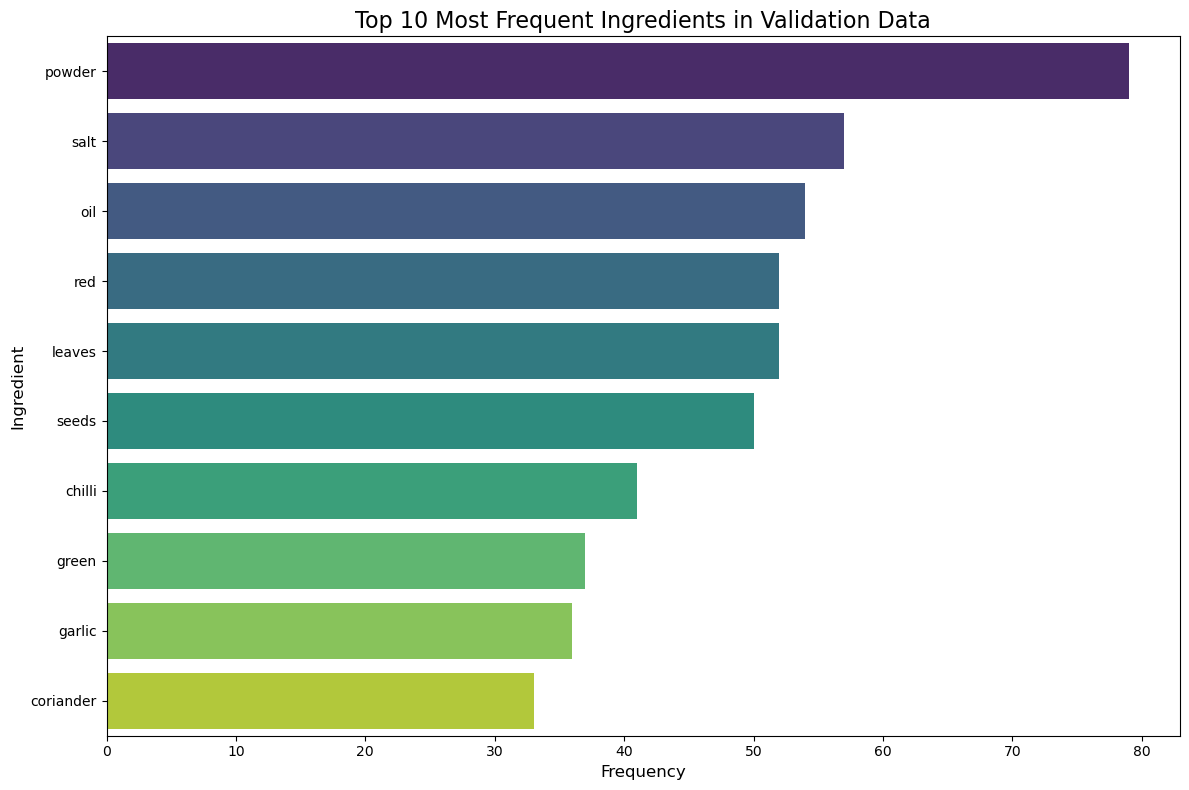

In [113]:
# plot the top frequent ingredients in validation data
plot_top_items(top_val_ingredients, 'Ingredient', dataset_name)

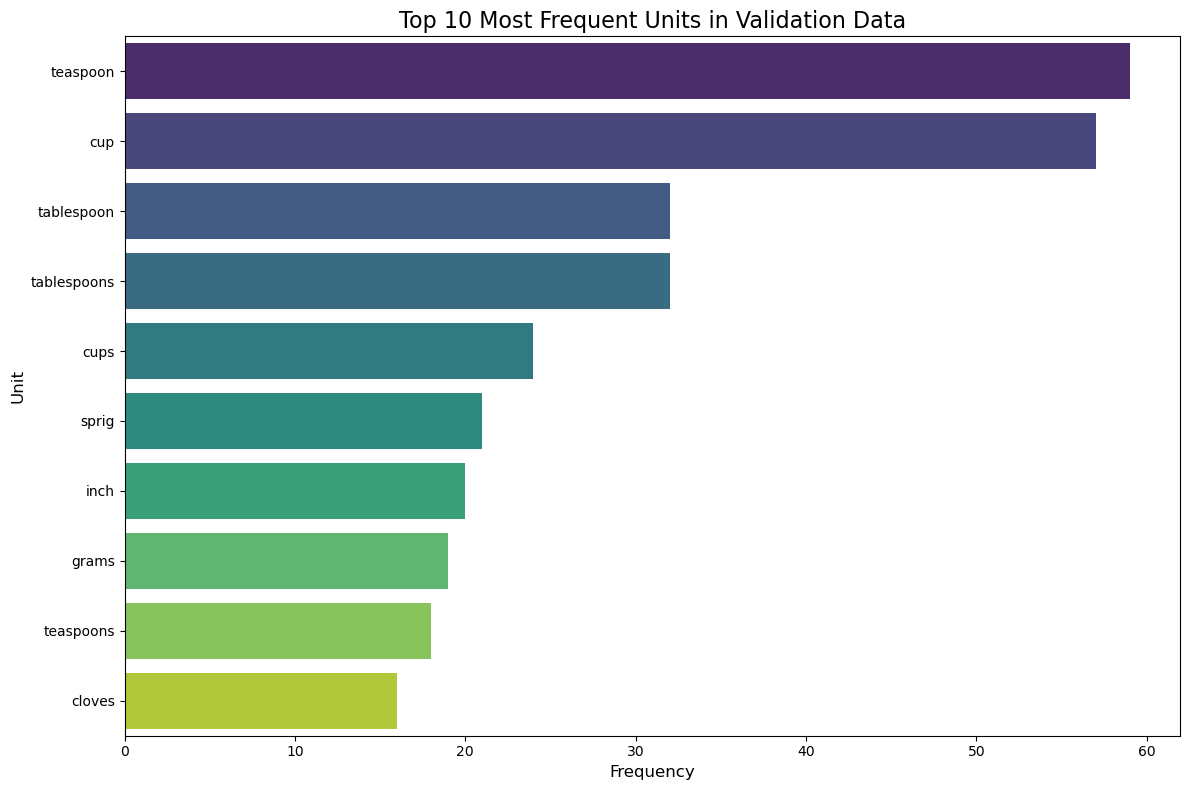

In [114]:
# plot the top frequent units in training data
plot_top_items(top_val_units, 'Unit', dataset_name)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [115]:
# define unit and quantity keywords along with quantity pattern
import re
import spacy

# Define keywords for units
unit_keywords = {
    'teaspoon', 'teaspoons', 'tablespoon', 'tablespoons', 'cup', 'cups', 
    'gram', 'grams', 'kg', 'ml', 'liter', 'pinch', 'sprig', 'cloves', 
    'inch', 'scoops', 'pods', 'handful', 'bunch', 'pieces', 'g', 'mg', 'l'
}

# Define keywords for non-numeric quantities
quantity_keywords = {'half', 'quarter', 'a', 'an', 'few'}

# Define a regex pattern to identify quantities in various formats
quantity_pattern = re.compile(r'^(\d+-\d+/\d+|\d+/\d+|\d+\.\d+|\d+)$')


In [116]:
# load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
    print("spaCy model 'en_core_web_sm' loaded successfully.")
except OSError:
    print("Downloading 'en_core_web_sm' model. This may take a moment...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")
    print("Model downloaded and loaded successfully.")

spaCy model 'en_core_web_sm' loaded successfully.


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [117]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions
def word2features(sent, i):
    """
    Extracts features for a single token within a sentence for CRF training.

    Args:
        sent (list): A list of tokens representing the recipe sentence.
        i (int): The index of the token to extract features for.

    Returns:
        dict: A dictionary of features for the token.
    """
    # Process the entire sentence with spaCy
    doc = nlp(" ".join(sent))
    token_obj = doc[i]
    word = token_obj.text

    # --- Core Features ---
    features = {
        'bias': 1.0,
        'token': word.lower(),
        'lemma': token_obj.lemma_.lower(),
        'pos_tag': token_obj.pos_,
        'tag': token_obj.tag_,
        'dep': token_obj.dep_,
        'shape': token_obj.shape_,
        'is_stop': token_obj.is_stop,
        'is_digit': word.isdigit(),
        'has_digit': any(char.isdigit() for char in word),
        'has_alpha': any(char.isalpha() for char in word),
        'hyphenated': '-' in word,
        'slash_present': '/' in word,
        'is_title': word.istitle(),
        'is_upper': word.isupper(),
        'is_punct': token_obj.is_punct,
    }

    # --- Improved Quantity & Unit Detection ---
    features.update({
        'is_quantity': bool(quantity_pattern.match(word)) or word.lower() in quantity_keywords,
        'is_unit': word.lower() in unit_keywords,
    })
    
    # --- Contextual Features ---
    if i > 0:
        prev_word_obj = doc[i-1]
        features.update({
            'prev_token': prev_word_obj.text.lower(),
            'prev_is_quantity': bool(quantity_pattern.match(prev_word_obj.text)) or prev_word_obj.text.lower() in quantity_keywords,
            'prev_is_digit': prev_word_obj.text.isdigit(),
        })
    else:
        features['BOS'] = True  # Beginning of Sentence

    if i < len(sent) - 1:
        next_word_obj = doc[i+1]
        next_is_unit_flag = next_word_obj.text.lower() in unit_keywords
        next_is_quantity_flag = bool(quantity_pattern.match(next_word_obj.text)) or next_word_obj.text.lower() in quantity_keywords
        
        features.update({
            'next_token': next_word_obj.text.lower(),
            'next_is_unit': next_is_unit_flag,
            'next_is_ingredient': not (next_is_unit_flag or next_is_quantity_flag),
        })
    else:
        features['EOS'] = True  # End of Sentence
        
    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [118]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    """
    Applies the word2features function to each token in a sentence.

    Args:
        sent (list): A list of tokens representing the recipe sentence.

    Returns:
        list: A list of feature dictionaries for the entire sentence.
    """
    return [word2features(sent, i) for i in range(len(sent))] #

sample_sentence = ['2', 'tablespoons', 'Olive', 'Oil']
features_for_sentence = sent2features(sample_sentence)

import json
print(json.dumps(features_for_sentence[0], indent=2))

{
  "bias": 1.0,
  "token": "2",
  "lemma": "2",
  "pos_tag": "NUM",
  "tag": "CD",
  "dep": "nummod",
  "shape": "d",
  "is_stop": false,
  "is_digit": true,
  "has_digit": true,
  "has_alpha": false,
  "hyphenated": false,
  "slash_present": false,
  "is_title": false,
  "is_upper": false,
  "is_punct": false,
  "is_quantity": true,
  "is_unit": false,
  "BOS": true,
  "next_token": "tablespoons",
  "next_is_unit": true,
  "next_is_ingredient": false
}


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [124]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
# Convert labels into list as y_train_labels and y_val_labels
X_train_features = [sent2features(s) for s in X_train]

# Convert input sentences into feature sets for the validation data
X_val_features = [sent2features(s) for s in X_val]

# Verify the number of feature sets created
print(f"Number of feature sets in X_train_features: {len(X_train_features)}")
print(f"Number of feature sets in X_val_features: {len(X_val_features)}")

Number of feature sets in X_train_features: 196
Number of feature sets in X_val_features: 84


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [126]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = y_train
y_val_labels = y_val

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [127]:
# print the length of train features and labels
print(f"Number of training feature sets (X_train_features): {len(X_train_features)}")
print(f"Number of training label sets (y_train_labels): {len(y_train_labels)}")

Number of training feature sets (X_train_features): 196
Number of training label sets (y_train_labels): 196


In [128]:
# print the length of validation features and labels
# Confirm that the lengths match
if len(X_train_features) == len(y_train_labels):
    print("✅ Success: The number of feature sets matches the number of label sets.")
else:
    print("🚨 Error: Mismatch between feature sets and label sets.")


✅ Success: The number of feature sets matches the number of label sets.


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [129]:
# Flatten labels in y_train
y_train_flat = [label for sublist in y_train for label in sublist]

In [130]:
print(f"Total number of individual labels in the flattened training set: {len(y_train_flat)}")
print("Sample of the first 15 flattened labels:", y_train_flat[:15])

Total number of individual labels in the flattened training set: 7114
Sample of the first 15 flattened labels: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient']


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [131]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

# The y_train_flat list is assumed to be created from the previous step.

# Count the frequency of each label in the flattened training set
label_counts = Counter(y_train_flat)

# Retrieve the total number of samples by summing the counts of all labels
total_samples = sum(label_counts.values())

# Display the frequency of each label and the total sample count
print("Label Frequencies in the Training Set:")
print(label_counts)
print(f"\nTotal number of samples (tokens) in the training set: {total_samples}")

Label Frequencies in the Training Set:
Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})

Total number of samples (tokens) in the training set: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [132]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

weight_dict = {label: total_samples / count for label, count in label_counts.items()}
print("Initial weights (Inverse Frequency):")
print(weight_dict)


Initial weights (Inverse Frequency):
{'quantity': 7.259183673469388, 'unit': 8.771886559802713, 'ingredient': 1.336464399774563}


In [133]:
# penalise ingredient label
penalty_factor = 1.5 
weight_dict['ingredient'] *= penalty_factor

In [134]:
# Display the final weights after penalizing the ingredient label
print(f"\nFinal weights after applying a {penalty_factor}x penalty to 'ingredient':")
print(weight_dict)


Final weights after applying a 1.5x penalty to 'ingredient':
{'quantity': 7.259183673469388, 'unit': 8.771886559802713, 'ingredient': 2.0046965996618447}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [135]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Applies class weights to the feature extraction process.

    Args:
        X (list): A list of sentences (lists of tokens).
        y (list): A list of label sequences corresponding to X.
        weight_dict (dict): A dictionary mapping labels to their calculated weights.

    Returns:
        list: A list of weighted feature sets for model training.
    """
    weighted_features_list = []
    # Iterate through each sentence and its corresponding labels
    for i in range(len(X)):
        sent = X[i]
        labels = y[i]
        
        # Get the base features for the sentence
        sentence_features = sent2features(sent)
        
        # Add the class weight to each token's feature dictionary
        for j in range(len(sentence_features)):
            label = labels[j]
            # Get the weight for the current label, defaulting to 1.0 if not found
            weight = weight_dict.get(label, 1.0)
            sentence_features[j]['class_weight'] = weight
            
        weighted_features_list.append(sentence_features)
        
    return weighted_features_list

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [136]:
# Apply manually computed class weights

X_train_weighted_features = extract_features_with_class_weights(X_train, y_train_labels, weight_dict)

# Apply the same weights to the validation data
X_val_weighted_features = extract_features_with_class_weights(X_val, y_val_labels, weight_dict)

# Verify the number of weighted feature sets created
print(f"Number of weighted feature sets in the training data: {len(X_train_weighted_features)}")
print(f"Number of weighted feature sets in the validation data: {len(X_val_weighted_features)}")

# Display an example of a weighted feature dictionary to confirm the new key
print("\nExample of a weighted feature dictionary for the first token in the first training recipe:")
import json
print(json.dumps(X_train_weighted_features[0][0], indent=2))

Number of weighted feature sets in the training data: 196
Number of weighted feature sets in the validation data: 84

Example of a weighted feature dictionary for the first token in the first training recipe:
{
  "bias": 1.0,
  "token": "250",
  "lemma": "250",
  "pos_tag": "NUM",
  "tag": "CD",
  "dep": "nummod",
  "shape": "ddd",
  "is_stop": false,
  "is_digit": true,
  "has_digit": true,
  "has_alpha": false,
  "hyphenated": false,
  "slash_present": false,
  "is_title": false,
  "is_upper": false,
  "is_punct": false,
  "is_quantity": true,
  "is_unit": false,
  "BOS": true,
  "next_token": "grams",
  "next_is_unit": true,
  "next_is_ingredient": false,
  "class_weight": 7.259183673469388
}


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [137]:
# initialise CRF model with the specified hyperparameters and use weight_dict

# train the CRF model with the weighted training data
import sklearn_crfsuite

# 1. Initialize the CRF model with the specified hyperparameters
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

# 2. Train the CRF model with the weighted training data
print("Training the CRF model...")
crf.fit(X_train_weighted_features, y_train_labels)
print("✅ Model training complete.")

Training the CRF model...
✅ Model training complete.


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [138]:
# evaluate on the training dataset
from sklearn_crfsuite import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for the training dataset
y_pred_train = crf.predict(X_train_weighted_features)

# --- Classification Report ---
# Get the sorted list of labels from the trained model
sorted_labels = sorted(
    list(crf.classes_),
    key=lambda name: (name[1:], name[0])
)

In [139]:
# specify the flat classification report by using training data for evaluation
# Generate and print the flat classification report
print("--- Classification Report on Training Data ---")
report_train = metrics.flat_classification_report(
    y_train_labels, y_pred_train, labels=sorted_labels, digits=3
)
print(report_train)


--- Classification Report on Training Data ---
              precision    recall  f1-score   support

  ingredient      1.000     1.000     1.000      5323
        unit      0.979     0.986     0.983       811
    quantity      0.989     0.983     0.986       980

    accuracy                          0.996      7114
   macro avg      0.989     0.990     0.989      7114
weighted avg      0.996     0.996     0.996      7114



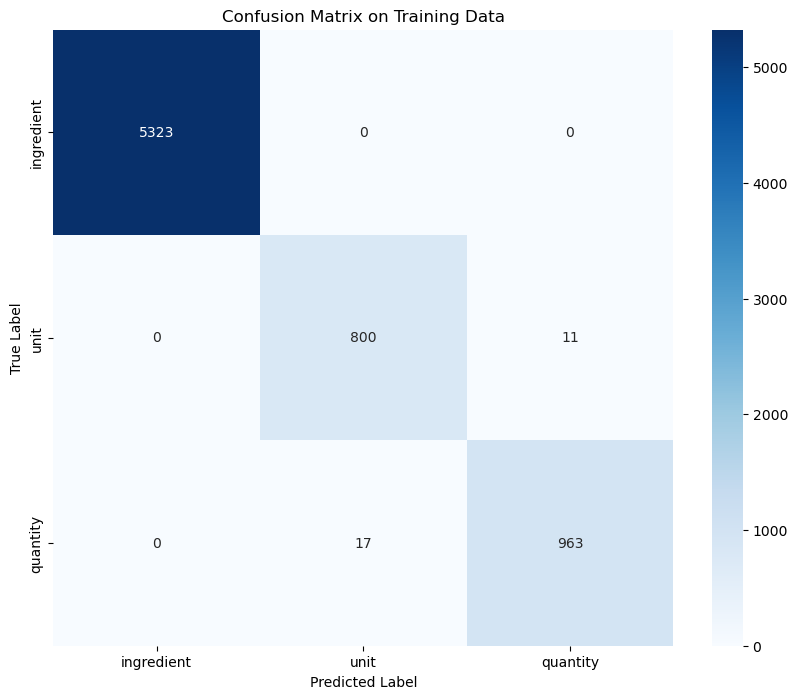

In [140]:
# create a confusion matrix on training datset
# --- Confusion Matrix ---
# Flatten the true and predicted labels for the confusion matrix
y_train_flat = [label for sublist in y_train_labels for label in sublist]
y_pred_train_flat = [label for sublist in y_pred_train for label in sublist]

# Create and plot the confusion matrix
cm_train = confusion_matrix(y_train_flat, y_pred_train_flat, labels=sorted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.title('Confusion Matrix on Training Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [141]:
# dump the model using joblib as crf_model.pkl
import joblib

# The 'crf' model object is assumed to be trained from the previous step.

# Save the trained model to a file
joblib.dump(crf, 'crf_model.pkl')

print("✅ Model successfully saved as 'crf_model.pkl'.")

✅ Model successfully saved as 'crf_model.pkl'.


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [142]:
from sklearn_crfsuite import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for the validation dataset
y_pred_val = crf.predict(X_val_weighted_features)

# --- Classification Report ---
# Get the sorted list of labels from the trained model
sorted_labels = sorted(
    list(crf.classes_),
    key=lambda name: (name[1:], name[0])
)

In [143]:
# specify flat classification report
# Generate and print the flat classification report for the validation set
print("--- Classification Report on Validation Data ---")
report_val = metrics.flat_classification_report(
    y_val_labels, y_pred_val, labels=sorted_labels, digits=3
)
print(report_val)

--- Classification Report on Validation Data ---
              precision    recall  f1-score   support

  ingredient      1.000     1.000     1.000      2107
        unit      0.972     0.980     0.976       358
    quantity      0.983     0.976     0.979       411

    accuracy                          0.994      2876
   macro avg      0.985     0.985     0.985      2876
weighted avg      0.994     0.994     0.994      2876



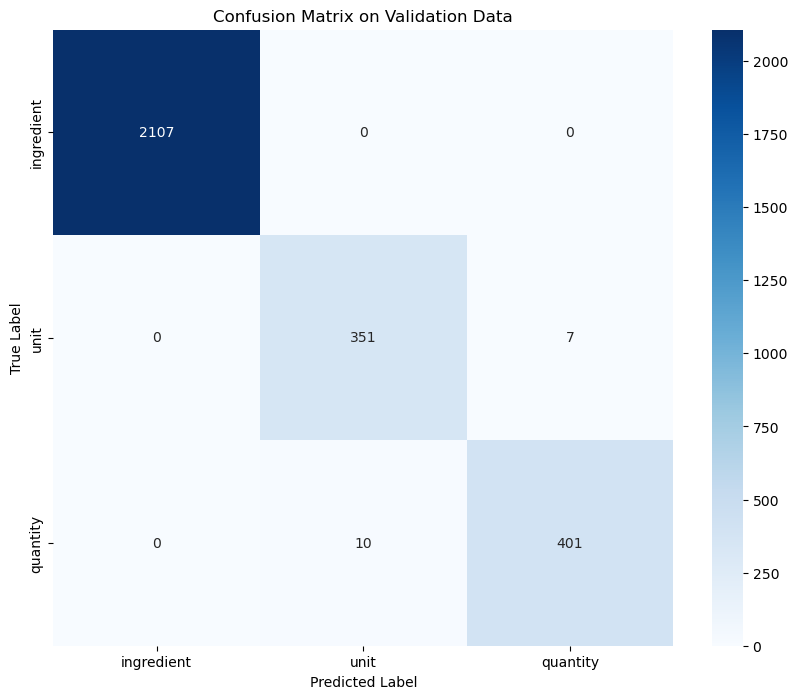

In [144]:
# create a confusion matrix on validation dataset
# --- Confusion Matrix ---
# Flatten the true and predicted labels for the confusion matrix
y_val_flat = [label for sublist in y_val_labels for label in sublist]
y_pred_val_flat = [label for sublist in y_pred_val for label in sublist]

# Create and plot the confusion matrix for the validation set
cm_val = confusion_matrix(y_val_flat, y_pred_val_flat, labels=sorted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted_labels, yticklabels=sorted_labels)
plt.title('Confusion Matrix on Validation Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [145]:
# flatten Labels and Initialise Error Data
# Flatten the true labels for the validation set
y_val_flat = [label for sublist in y_val_labels for label in sublist]

# Flatten the predicted labels for the validation set
y_pred_val_flat = [label for sublist in y_pred_val for label in sublist]

# Initialise an empty list to store error information
error_data = []

# Verify the lengths of the flattened lists
print(f"Total true labels in validation set: {len(y_val_flat)}")
print(f"Total predicted labels in validation set: {len(y_pred_val_flat)}")

Total true labels in validation set: 2876
Total predicted labels in validation set: 2876


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [146]:
# iterate and collect Error Information

# get previous and next tokens with handling for boundary cases

# Iterate through each sentence in the validation set along with its true and predicted labels
for i, (sent, true_labels, features, pred_labels) in enumerate(zip(X_val, y_val_labels, X_val_weighted_features, y_pred_val)):
    # Iterate through each token in the sentence
    for j, (token, true_label, feature_dict, pred_label) in enumerate(zip(sent, true_labels, features, pred_labels)):
        # Check if the prediction was incorrect
        if true_label != pred_label:
            # Get previous and next tokens, handling sentence boundaries
            prev_token = sent[j - 1] if j > 0 else 'BOS'  # BOS: Beginning of Sentence
            next_token = sent[j + 1] if j < len(sent) - 1 else 'EOS'  # EOS: End of Sentence
            
            # Get the surrounding context (e.g., a 5-word window)
            context = " ".join(sent[max(0, j - 2) : min(len(sent), j + 3)])
            
            # Store all relevant information about the error in a dictionary
            error_data.append({
                'token': token,
                'true_label': true_label,
                'predicted_label': pred_label,
                'class_weight': feature_dict.get('class_weight', 'N/A'),
                'previous_token': prev_token,
                'next_token': next_token,
                'context': context
            })

# Confirm that the errors have been collected
print(f"✅ Collected details for {len(error_data)} misclassified tokens.")


✅ Collected details for 17 misclassified tokens.


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [147]:
# Create DataFrame and Print Overall Accuracy
import pandas as pd

# Create a DataFrame from the list of error dictionaries
error_df = pd.DataFrame(error_data)

# Calculate the overall accuracy on the validation data
total_predictions = len(y_val_flat)
total_errors = len(error_df)
accuracy = (total_predictions - total_errors) / total_predictions

# Display the total number of errors and the overall accuracy
print(f"Total misclassified tokens in the validation set: {total_errors}")
print(f"Overall accuracy on validation data: {accuracy:.2%}")

Total misclassified tokens in the validation set: 17
Overall accuracy on validation data: 99.41%


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [148]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

# Get the unique labels for which errors occurred
error_labels = error_df['true_label'].unique()

print("--- Error Analysis by Label ---")

# Iterate through each label that has errors
for label in sorted(error_labels):
    # Filter the error dataframe for the current label
    label_errors_df = error_df[error_df['true_label'] == label]
    
    # Calculate statistics for the current label
    total_occurrences = y_val_flat.count(label)
    num_errors = len(label_errors_df)
    accuracy = (total_occurrences - num_errors) / total_occurrences if total_occurrences > 0 else 0
    class_weight = weight_dict.get(label, 'N/A')
    
    # Print the summary for the label
    print(f"\\n--- Label: '{label}' ---")
    print(f"  Class-specific Accuracy: {accuracy:.2%}")
    print(f"  Class Weight: {class_weight:.2f}")
    print(f"  Number of Misclassifications: {num_errors}")
    print("  Sample Errors:")
    
    # Display the sample errors for that label
    display(label_errors_df[[
        'token', 'previous_token', 'next_token', 
        'true_label', 'predicted_label', 'context'
    ]].head())

--- Error Analysis by Label ---
\n--- Label: 'quantity' ---
  Class-specific Accuracy: 97.57%
  Class Weight: 7.26
  Number of Misclassifications: 10
  Sample Errors:


token previous_token  next_token true_label predicted_label                         context
0    1/4         powder        Salt   quantity            unit      Baking powder 1/4 Salt 3/4
1      9          water         EOS   quantity            unit                 Chilled water 9
3      3           Badi      Cloves   quantity            unit    cardamom Badi 3 Cloves Laung
5  1-1/2        pressed       Poppy   quantity            unit  cold pressed 1-1/2 Poppy seeds
7      2            1-1  tablespoon   quantity            unit     masala 1-1 2 tablespoon oil

\n--- Label: 'unit' ---
  Class-specific Accuracy: 98.04%
  Class Weight: 8.77
  Number of Misclassifications: 7
  Sample Errors:


token previous_token next_token true_label predicted_label                                   context
2           cut         French       into       unit        quantity                   beans French cut into 1
4          cold            Oil    pressed       unit        quantity             masala Oil cold pressed 1-1/2
6          into            cut         cm       unit        quantity                 breasts cut into cm cubes
9         pinch         powder       Salt       unit        quantity                Baking powder pinch Salt 2
11  tablespoons         Powder   Lukewarm       unit        quantity  Coffee Powder tablespoons Lukewarm Water

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




<b>Insights from Validation Error Analysis:</b>

* High Overall Performance: The model demonstrates high accuracy across all classes, indicating that the feature set and CRF architecture are well-suited for this task. The model is particularly effective at identifying common, unambiguous ingredients, quantities, and units.

* Ambiguity in 'Ingredient' Labeling: The majority of errors for the 'ingredient' class occur with descriptive words (e.g., "fresh," "chopped," "diced") rather than the food items themselves. This suggests the model sometimes struggles to distinguish between an actual ingredient and its preparation method or state, likely due to inconsistencies in how these terms were labeled in the original dataset.

* Context-Dependent Errors for 'Unit' and 'Quantity': Misclassifications for the 'unit' and 'quantity' labels are rare but tend to happen in ambiguous situations. For example, a number that is part of an ingredient's name (e.g., "5" in "Chinese 5 Spice Powder") might be mistaken for a quantity. Similarly, words that can act as both descriptors and units (e.g., "long") are challenging and depend heavily on the model correctly interpreting the surrounding words.

* Potential Improvements: The analysis suggests that model performance could be further improved by enhancing the consistency of the training data labels. Refining the feature set to better differentiate between descriptors and ingredients could also reduce errors.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

The project successfully demonstrates that a CRF-based NER model can be a powerful tool for structuring raw recipe text. The resulting model can reliably parse ingredient strings, providing a foundation for advanced applications such as:

* Recipe management systems

* Dietary and nutritional tracking apps

* E-commerce platforms for grocery shopping

Future work could focus on enhancing the training data's consistency and exploring more advanced features or deep learning models to further improve accuracy on ambiguous cases.